## Load Env Vars

In [1]:
# set env vars
from dotenv import load_dotenv

load_dotenv()

True

## Components

In [1]:
# llm
import getpass
import os
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.chat_models import init_chat_model

if not os.environ.get("GOOGLE_API_KEY"):
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")
    
llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

In [2]:
# Embeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [3]:
# in-memory vector store
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [4]:
# # Pinecone Vector stores
# from langchain_pinecone import PineconeVectorStore
# from pinecone import Pinecone, ServerlessSpec

# index_name = "any-chatbot-index"
# EMBED_DIM = len(embeddings.embed_query("Hello World"))

# pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))

# if not pc.has_index(index_name):
#     pc.create_index(
#         name=index_name, 
#         dimension=EMBED_DIM,
#         metric="cosine",
#         spec=ServerlessSpec(
#             cloud="aws",
#             region="us-east-1"
#         )
#     )

# index = pc.Index(index_name)

# vector_store = PineconeVectorStore(embedding=embeddings, index=index)

## Load Documents

In [5]:
# Load the documents
from langchain.document_loaders import PyPDFLoader

file_path = "../../data/nke-10k-2023.pdf"
loader = PyPDFLoader(file_path)

docs = loader.load()

print(len(docs))

107


In [ ]:
# Load the documents
from langchain.document_loaders import (
    DirectoryLoader,
    PyPDFLoader,
    TextLoader,
    UnstructuredWordDocumentLoader,
    Unsc
)
from langchain.document_loaders import UnstructuredFileLoader

loader = DirectoryLoader(
    "../../data",
    glob="**/*",
    loader_cls=UnstructuredFileLoader
)

docs = loader.load()

print(f"Loaded {len(docs)} docs using the universal unstructured loader")

Error loading file ../../data/nke-10k-2023.pdf


ImportError: partition_pdf() is not available because one or more dependencies are not installed. Use: pip install "unstructured[pdf]" (including quotes) to install the required dependencies

In [6]:
# Splitting
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
all_splits = text_splitter.split_documents(docs)

len(all_splits)

516

In [7]:
# index the documents
ids = vector_store.add_documents(documents=all_splits)

print(len(ids))

516


## LangGraph

In [10]:
# turn retrieval step as a tool

from langchain_core.tools import tool

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query"""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [11]:
# build the agent lang graph
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

# build checkpointer
memory = MemorySaver()
# build agent
agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)



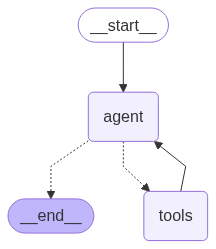

In [12]:
# Display the graph
from IPython.display import Image, display

display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [ ]:
# specify an ID for the thread
import random
# config = {"configurable": {"thread_id": "abc123"}}
config = {"configurable": {"thread_id": random.random()}}

input_message = (
    "First retrieve what the revenue for Nike in 2023 was using the functional call.\n\n"
    "Once you get the answer, do a second retrieve to tell me which distribution centers nike have.\n\n"
    "Once you get the second answer,, tell me how many employees nike has. You can retreive MULTIPLE TIMES\n\n"
    "Base your answers only on the retrieved information thorugh the functional call you have."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

First retrieve what the revenue for Nike in 2023 was using the functional call.

Once you get the answer, do a second retrieve to tell me which distribution centers nike have.

Once you get the second answer,, tell me how many employees nike has. You can retreive MULTIPLE TIMESBase your answers only on the retrieved information thorugh the functional call you have.
================================== Ai Message ==================================
Tool Calls:
  retrieve (a40bc5c0-bc25-4518-aae3-9cd4348837df)
 Call ID: a40bc5c0-bc25-4518-aae3-9cd4348837df
  Args:
    query: What was the revenue for Nike in 2023?
================================= Tool Message =================================
Name: retrieve

Source: {'producer': 'EDGRpdf Service w/ EO.Pdf 22.0.40.0', 'creator': 'EDGAR Filing HTML Converter', 'creationdate': '2023-07-20T16:22:00-04:00', 'title': '0000320187-23-000039', 'author': 'EDGAR Online, 